## Import


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations

import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

In [ ]:
import random
random.seed(42)

In [ ]:
testpath = 'amazon_test_data.csv'
trainpath = 'amazon_train_data.csv'

## Rhapsody Implementation

In [ ]:
def rhapsody_algorithm(data_path, T, K, working_columns):
    """
    Rhapsody Algorithm for ABAC Policy Mining

    Parameters:
    - data_path: Path to CSV file with columns ['userID', 'resourceID', 'operation']
    - T: Minimum request coverage threshold (≥ 1)
    - K: Reliability threshold (∈ [0, 1])

    When to use T and K:
    - T: Use to filter out rules that cover too few requests (noise filtering)
      - Higher T = more conservative, fewer but more significant rules
      - Lower T = more permissive, more rules including rare patterns
    - K: Use to ensure rule reliability/confidence
      - Higher K = more reliable rules, stricter quality control
      - Lower K = more permissive, allows less reliable rules
    """

    # Load and prepare data
    data = pd.read_csv(data_path)
    print(f"Loaded {len(data)} records")

    # STAGE 1: Compute FreqRules, nU×P, and nA
    print("\n=== STAGE 1: Computing Frequent Rules ===")
    freq_rules, nUP, nA = stage1(data, T, working_columns)

    # STAGE 2: Compute RelRules (T-reliable rules)
    print("\n=== STAGE 2: Computing Reliable Rules ===")
    rel_rules = stage2(freq_rules, nUP, nA, T, K)

    # STAGE 3: Remove redundant rules
    print("\n=== STAGE 3: Removing Redundant Rules ===")
    short_rules = stage3(rel_rules, nUP, nA, freq_rules)

    return short_rules, nUP, nA

In [ ]:
# def stage1(data, T):
def stage1(data, T, working_columns):
    """
    Stage 1: Compute FreqRules, nU×P, and nA
    """

    def create_atoms(row):
            atoms = []
            for col in working_columns:
                if pd.notna(row[col]):  # Handle NaN values
                    atoms.append(f"{col}={row[col]}")
            return frozenset(atoms)

    data['atoms'] = data.apply(create_atoms, axis=1)

    # Step 2: Create transaction list F = {A(u,p) : (u,p) ∈ U×P}
    transactions = list(data['atoms'])
    print(f"Created {len(transactions)} transactions")

    # Step 3: Apply APRIORI with threshold T
    te = TransactionEncoder()
    te_array = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_array, columns=te.columns_)

    # Calculate minimum support as T/total_transactions
    min_support = T / len(transactions)
    print(f"Minimum support: {min_support:.4f} (T={T}, total transactions={len(transactions)})")

    # Get frequent itemsets
    freq_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

    if freq_itemsets.empty:
        print("No frequent itemsets found with the given threshold")
        return [], {}, {}, {}

    # Step 4: Convert itemsets to rules (FreqRules)
    freq_rules = []
    nUP = {}  # nU×P function

    for _, row in freq_itemsets.iterrows():
        itemset = row['itemsets']
        rule = " ∧ ".join(sorted(itemset))
        freq_rules.append(rule)

        # Count requests covered by this rule (support * total transactions)
        nUP[rule] = int(row['support'] * len(transactions))

    print(f"Generated {len(freq_rules)} frequent rules")

    # Step 5: Compute nA (number of attributes per rule)
    nA = {}
    for rule in freq_rules:
        nA[rule] = len(rule.split(" ∧ "))

    # Initialize nA to 0
    for rule in freq_rules:
        nA[rule] = 0

    # # This counts how many attribute assignments each rule covers
    for _, row in data.iterrows():
        request_atoms = set()
        for col in working_columns:
              if pd.notna(row[col]):
                  request_atoms.add(f"{col}={row[col]}")

        for rule in freq_rules:
            rule_atoms = set(rule.split(" ∧ "))
            if rule_atoms.issubset(request_atoms):
                nA[rule] += 1

    print(f"\nSample nA values:")
    for i, rule in enumerate(freq_rules[:3]):
          print(f"  Rule {i+1}: {rule}")
          print(f"    nU×P = {nUP[rule]} (requests covered)")
          print(f"    nA = {nA[rule]} (attribute combinations satisfied)")

    return freq_rules, nUP, nA

In [ ]:
def stage2(freq_rules, nUP, nA, T, K):
    """
    Stage 2: Compute RelRules (rules with T-reliability ≥ K)
    """
    unrel_rules = set()

    # Check all pairs of rules
    for r1 in freq_rules:
        for r2 in freq_rules:
            if r1 != r2:
                # Check if r2 proves that RelT(r1) < K
                if proves_unreliability(r1, r2, nUP, T, K):
                    unrel_rules.add(r1)

    # Compute RelRules = FreqRules \ UnrelRules
    rel_rules = [rule for rule in freq_rules if rule not in unrel_rules]

    print(f"Unreliable rules: {len(unrel_rules)}")
    print(f"Reliable rules: {len(rel_rules)}")

    return rel_rules

def proves_unreliability(r1, r2, nUP, T, K):
    """
    Check if r2 proves that RelT(r1) < K

    Conditions:
    (i) r2 is a refinement of r1 (r1 ⊆ r2)
    (ii) |r2_U×P| ≥ T
    (iii) Conf(r2) < K
    """
    r1_atoms = set(r1.split(" ∧ "))
    r2_atoms = set(r2.split(" ∧ "))

    # (i) r2 is a refinement of r1 (r1 is subset of r2)
    if not r1_atoms.issubset(r2_atoms):
        return False

    # (ii) r2 covers at least T requests
    if nUP[r2] < T:
        return False

    # (iii) Confidence of r2 < K (Normalized Confidence)
    # Conf(r2) = |r2_U×P| / (|r1_U×P| + |r2_U×P|)
    confidence = nUP[r2] / (nUP[r1] + nUP[r2])

    if confidence < K:
        return True

    return False

In [ ]:
def stage3(rel_rules, nUP, nA, freq_rules):
    """
    Stage 3: Remove redundant rules
    """
    subsumed = set()

    # Check all pairs of rules in RelRules
    for r1 in rel_rules:
        for r2 in rel_rules:
            if r1 != r2:
                # Check if r1 and r2 are equivalent and r2 is shorter
                if are_equivalent(r1, r2, nUP, freq_rules) and is_shorter(r2, r1):
                    subsumed.add(r1)

    # Compute ShortRules = RelRules \ Subsumed
    short_rules = [rule for rule in rel_rules if rule not in subsumed]

    # Sort by number of attributes (shorter rules first)
    short_rules = sorted(short_rules, key=lambda x: nA[x])

    print(f"Subsumed rules: {len(subsumed)}")
    print(f"Final concise rules: {len(short_rules)}")

    return short_rules

def are_equivalent(r1, r2, nUP, freq_rules):
    """
    Simplified equivalence: rules are equivalent if they have same coverage
    and one subsumes the other
    """
    if nUP[r1] != nUP[r2]:
        return False

    r1_atoms = set(r1.split(" ∧ "))
    r2_atoms = set(r2.split(" ∧ "))

    # If one rule's conditions are a subset of the other's, they're equivalent
    # when they have the same coverage
    return r1_atoms.issubset(r2_atoms) or r2_atoms.issubset(r1_atoms)

def is_shorter(r2, r1):
    """
    Check if r2 is shorter than r1 (has fewer attributes/conditions)
    """
    r1_atoms = r1.split(" ∧ ")
    r2_atoms = r2.split(" ∧ ")
    return len(r2_atoms) < len(r1_atoms)

In [ ]:
def display_results(rules, nUP, nA, title):
    """Display rules with their statistics"""
    print(f"\n{title}:")
    if not rules:
        print("No rules found.")
        return

    for rule in rules:
        print(f"{rule}  |  nU×P: {nUP[rule]}  |  nA: {nA[rule]}")

## Test

### Version 1

#### Test Implementation

In [ ]:
class RHAPSODYTester:
    def __init__(self, test_data_path, rules, working_columns, nUP=None, nA=None, T=0.8, K=3):

        self.test_data_path = test_data_path
        self.rules = rules if rules else []
        self.nUP = nUP if nUP else {}
        self.nA = nA if nA else {}
        self.T = T
        self.K = K
        self.working_columns = working_columns

        # Data containers
        self.test_data = None
        self.predictions = None
        self.true_labels = None
        self.rule_coverage = None

    def load_test_data(self):
        """Load the test dataset"""
        try:
            self.test_data = pd.read_csv(self.test_data_path)
            # Shuffle dataset
            self.test_data = self.test_data.sample(frac=1, random_state=42).reset_index(drop=True)

            print(f"Loaded test dataset with {len(self.test_data)} records")
            print(f"Columns: {list(self.test_data.columns)}")

            # Check for true_label column
            if 'access_granted' not in self.test_data.columns:
                raise ValueError("Dataset must contain Access Granted column")

            self.true_labels = self.test_data['access_granted'].values
            print(f"True label distribution:")
            print(self.test_data['access_granted'].value_counts())

            return True

        except Exception as e:
            print(f"Error loading test data: {e}")
            return False

    def predict_with_rules(self, instance):
        """
        Predict decision for an instance using RHAPSODY rules
        """
        if not self.rules:
            return 0, False

        # Create atoms for the instance (handle missing values)
        instance_atoms = set()

        # Skip metadata columns
        skip_columns = []

        for key, value in instance.items():
            if key not in skip_columns and pd.notna(value):
                instance_atoms.add(f"{key}={value}")

        # Check if any rule matches the instance
        for rule in self.rules:
            rule_atoms = set(rule.split(" ∧ "))
            if rule_atoms.issubset(instance_atoms):
                return 1, True

        return 0, False

    def make_predictions(self):
        """Make predictions for all test instances"""
        if self.test_data is None:
            print("Test data not loaded")
            return False

        print("Making predictions...")
        predictions = []
        rule_coverage = []

        for _, row in self.test_data.iterrows():
            instance = row.to_dict()
            prediction, rule_matched = self.predict_with_rules(instance)
            predictions.append(prediction)
            rule_coverage.append(rule_matched)

        self.predictions = np.array(predictions)
        self.rule_coverage = np.array(rule_coverage)

        # Add predictions as a column to the dataset
        self.test_data['predicted_label'] = self.predictions
        self.test_data['rule_covered'] = self.rule_coverage

        # Print coverage statistics
        covered_count = np.sum(self.rule_coverage)
        total_count = len(self.rule_coverage)
        coverage_percentage = (covered_count / total_count) * 100

        print(f"\nRule Coverage Statistics:")
        print(f"Total test instances: {total_count}")
        print(f"Instances covered by rules: {covered_count}")
        print(f"Coverage percentage: {coverage_percentage:.2f}%")
        print(f"Instances not covered by rules: {total_count - covered_count}")

        print(f"Prediction distribution:")
        unique, counts = np.unique(self.predictions, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"  {label}: {count}")

        return True

    def calculate_basic_metrics(self):
      """Calculate basic classification metrics"""
      if self.predictions is None or self.true_labels is None:
          print("Predictions or true labels not available")
          return None

      # Convert to binary format for sklearn metrics - ensure consistent types
      y_true_binary = np.array(self.true_labels).astype(int)
      y_pred_binary = np.array(self.predictions).astype(int)

      # Calculate overall metrics (all instances)
      overall_metrics = {
          'overall_accuracy': accuracy_score(y_true_binary, y_pred_binary),
          'overall_precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
          'overall_recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
          'overall_f1_score': f1_score(y_true_binary, y_pred_binary, zero_division=0),
      }

      # Calculate metrics for rule-covered instances only
      if self.rule_coverage is not None:
          covered_indices = self.rule_coverage == True

          if np.sum(covered_indices) > 0:
              y_true_covered = y_true_binary[covered_indices]
              y_pred_covered = y_pred_binary[covered_indices]

              tn_c, fp_c, fn_c, tp_c = confusion_matrix(y_true_covered, y_pred_covered).ravel()

              covered_metrics = {
                  'rule_covered_accuracy': accuracy_score(y_true_covered, y_pred_covered),
                  'rule_covered_precision': precision_score(y_true_covered, y_pred_covered, zero_division=0),
                  'rule_covered_recall': recall_score(y_true_covered, y_pred_covered, zero_division=0),
                  'rule_covered_f1_score': f1_score(y_true_covered, y_pred_covered, zero_division=0),
                  'rule_coverage_percentage': (np.sum(covered_indices) / len(y_true_binary)) * 100,
                  'rule_covered_fpr': fp_c / (fp_c + tn_c) if (fp_c + tn_c) > 0 else 0,
                  'rule_covered_tnr': tn_c / (tn_c + fp_c) if (tn_c + fp_c) > 0 else 0,
                  'rule_covered_tpr': tp_c / (tp_c + fn_c) if (tp_c + fn_c) > 0 else 0,
                  'rule_covered_specificity': tn_c / (tn_c + fp_c) if (tn_c + fp_c) > 0 else 0,
              }
          else:
              covered_metrics = {
                'rule_covered_accuracy': 0,
                'rule_covered_precision': 0,
                'rule_covered_recall': 0,
                'rule_covered_f1_score': 0,
                'rule_coverage_percentage': 0,
                'rule_covered_fpr': 0,
                'rule_covered_tnr': 0,
                'rule_covered_tpr': 0,
                'rule_covered_specificity': 0,
            }

          # Calculate metrics for non-covered instances
          non_covered_indices = self.rule_coverage == False
          if np.sum(non_covered_indices) > 0:
              y_true_non_covered = y_true_binary[non_covered_indices]
              y_pred_non_covered = y_pred_binary[non_covered_indices]

              non_covered_metrics = {
                  'non_covered_accuracy': accuracy_score(y_true_non_covered, y_pred_non_covered),
                  'non_covered_precision': precision_score(y_true_non_covered, y_pred_non_covered, zero_division=0),
                  'non_covered_recall': recall_score(y_true_non_covered, y_pred_non_covered, zero_division=0),
                  'non_covered_f1_score': f1_score(y_true_non_covered, y_pred_non_covered, zero_division=0),
              }
          else:
              non_covered_metrics = {
                  'non_covered_accuracy': 0,
                  'non_covered_precision': 0,
                  'non_covered_recall': 0,
                  'non_covered_f1_score': 0,
              }
      else:
          covered_metrics = {}
          non_covered_metrics = {}

      # Calculate FPR and TNR for confusion matrix
      tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
      fpr_tnr_metrics = {
          'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
          'tnr': tn / (tn + fp) if (tn + fp) > 0 else 0,
          'tpr': tp / (tp + fn) if (tp + fn) > 0 else 0,
          'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
      }

      # Combine all metrics
      metrics = {**overall_metrics, **covered_metrics, **non_covered_metrics, **fpr_tnr_metrics}

      # Print mismatched instances
      mismatched_instances = self.test_data[self.true_labels != self.predictions]
      if not mismatched_instances.empty:
          print("\n"+"="*20+"Mismatch Analysis"+"="*20)
          print(f"Total mismatched instances: {len(mismatched_instances)}")

          # Analyze mismatches by rule coverage
          if self.rule_coverage is not None:
              covered_mismatches = mismatched_instances[mismatched_instances['rule_covered'] == True]
              non_covered_mismatches = mismatched_instances[mismatched_instances['rule_covered'] == False]

              print(f"Mismatches in rule-covered instances: {len(covered_mismatches)}")
              print(f"Mismatches in non-covered instances: {len(non_covered_mismatches)}")

      mismatched_instances.to_csv("mismatched_instances.csv", index=False)


      return metrics

    def print_results_summary(self, basic_metrics):
      """Print a clean summary of results"""
      print("\n" + "="*60)
      print("RHAPSODY EVALUATION RESULTS SUMMARY")
      print("="*60)

      # Overall Performance
      print("\n--- Overall Performance (All Test Instances) ---")
      print(f"Overall Accuracy: {basic_metrics.get('overall_accuracy', 0):.4f}")
      print(f"Overall Precision: {basic_metrics.get('overall_precision', 0):.4f}")
      print(f"Overall Recall: {basic_metrics.get('overall_recall', 0):.4f}")
      print(f"Overall F1-Score: {basic_metrics.get('overall_f1_score', 0):.4f}")

      # Rule Coverage Analysis
      if 'rule_coverage_percentage' in basic_metrics:
          print(f"\n--- Rule Coverage Analysis ---")
          print(f"Rule Coverage: {basic_metrics['rule_coverage_percentage']:.2f}% of test instances")

          print(f"\n--- Performance on Rule-Covered Instances ---")
          print(f"Accuracy: {basic_metrics.get('rule_covered_accuracy', 0):.4f}")
          print(f"Precision: {basic_metrics.get('rule_covered_precision', 0):.4f}")
          print(f"Recall: {basic_metrics.get('rule_covered_recall', 0):.4f}")
          print(f"F1-Score: {basic_metrics.get('rule_covered_f1_score', 0):.4f}")
          print(f"FPR (False Positive Rate): {basic_metrics.get('rule_covered_fpr', 0):.4f}")
          print(f"TNR (True Negative Rate): {basic_metrics.get('rule_covered_tnr', 0):.4f}")
          print(f"TPR (True Positive Rate): {basic_metrics.get('rule_covered_tpr', 0):.4f}")
          print(f"Specificity: {basic_metrics.get('rule_covered_specificity', 0):.4f}")

          print(f"\n--- Performance on Non-Covered Instances ---")
          print(f"Accuracy: {basic_metrics.get('non_covered_accuracy', 0):.4f}")
          print(f"Precision: {basic_metrics.get('non_covered_precision', 0):.4f}")
          print(f"Recall: {basic_metrics.get('non_covered_recall', 0):.4f}")
          print(f"F1-Score: {basic_metrics.get('non_covered_f1_score', 0):.4f}")

      # Additional metrics for confusion matrix
      print(f"\n--- Additional Metrics ---")
      print(f"FPR (False Positive Rate): {basic_metrics.get('fpr', 0):.4f}")
      print(f"TNR (True Negative Rate): {basic_metrics.get('tnr', 0):.4f}")
      print(f"TPR (True Positive Rate): {basic_metrics.get('tpr', 0):.4f}")
      print(f"Specificity: {basic_metrics.get('specificity', 0):.4f}")

      # Rule statistics
      rule_stats = self.get_rule_statistics()
      print("\n--- Rule Statistics ---")
      for stat, value in rule_stats.items():
          print(f"{stat.replace('_', ' ').title()}: {value}")

    def get_confusion_matrix(self):
        """Get confusion matrix"""

        if self.predictions is None or self.true_labels is None:
            return None

        return confusion_matrix(self.true_labels, self.predictions, labels=[True, False])

    def get_classification_report(self):
        """Get detailed classification report"""
        if self.predictions is None or self.true_labels is None:
            return None

        return classification_report(self.true_labels, self.predictions,
                                   target_names=[True, False], output_dict=True)

    def cross_validate(self, n_folds=5, random_state=42):
      """Perform k-fold cross validation"""
      if self.test_data is None:
          print("Test data not loaded")
          return None

      kfold = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
      cv_results = []

      print(f"Performing {n_folds}-fold cross validation...")

      for fold, (train_idx, test_idx) in enumerate(kfold.split(self.test_data)):
          print(f"Fold {fold + 1}/{n_folds}")

          # Get test subset for this fold
          test_subset = self.test_data.iloc[test_idx]
          true_subset = test_subset['access_granted'].values

          # Make predictions for this fold
          pred_subset = []
          for _, row in test_subset.iterrows():
              instance = row.to_dict()
              prediction, _ = self.predict_with_rules(instance)  # Updated to handle tuple return
              pred_subset.append(prediction)

          pred_subset = np.array(pred_subset)

          # Convert to consistent binary format for sklearn metrics
          y_true_binary = np.array(true_subset).astype(int)  # Convert boolean to int
          y_pred_binary = np.array(pred_subset).astype(int)  # Ensure int format

          fold_metrics = {
              'fold': fold + 1,
              'accuracy': accuracy_score(y_true_binary, y_pred_binary),
              'precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
              'recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
              'f1_score': f1_score(y_true_binary, y_pred_binary, zero_division=0)
          }

          cv_results.append(fold_metrics)

      # Aggregate results
      metrics = ['accuracy', 'precision', 'recall', 'f1_score']
      aggregated = {}

      for metric in metrics:
          values = [result[metric] for result in cv_results]
          aggregated[f'{metric}_mean'] = np.mean(values)
          aggregated[f'{metric}_std'] = np.std(values)
          aggregated[f'{metric}_min'] = np.min(values)
          aggregated[f'{metric}_max'] = np.max(values)

      return {'fold_results': cv_results, 'aggregated': aggregated}

    def get_rule_statistics(self):
        """Get statistics about the rules"""
        if not self.rules:
            return {'rule_count': 0}

        stats = {
            'rule_count': len(self.rules),
            'average_conditions_per_rule': 0,
            'total_coverage': sum(self.nUP.values()) if self.nUP else 0,
            'average_coverage_per_rule': 0
        }

        # Calculate average conditions per rule
        condition_counts = [len(rule.split(" ∧ ")) for rule in self.rules]
        stats['average_conditions_per_rule'] = np.mean(condition_counts)

        # Calculate coverage statistics
        if self.nUP:
            coverages = [self.nUP.get(rule, 0) for rule in self.rules]
            stats['average_coverage_per_rule'] = np.mean(coverages)
            stats['min_coverage'] = min(coverages)
            stats['max_coverage'] = max(coverages)

        return stats

    def get_rule_covered_confusion_matrix(self):
      """Get confusion matrix for only rule-covered instances"""
      if self.predictions is None or self.true_labels is None or self.rule_coverage is None:
          return None

      # Filter for rule-covered instances only
      covered_indices = self.rule_coverage == True

      if np.sum(covered_indices) == 0:
          return None

      # Convert to consistent binary format
      y_true_covered = np.array(self.true_labels[covered_indices]).astype(int)
      y_pred_covered = np.array(self.predictions[covered_indices]).astype(int)

      return confusion_matrix(y_true_covered, y_pred_covered, labels=[True, False])

    def run_complete_evaluation(self, include_cv=True, n_folds=5):
        """Run complete evaluation pipeline"""
        print("Starting RHAPSODY evaluation...")

        # Load data
        if not self.load_test_data():
            return None

        # Make predictions
        if not self.make_predictions():
            return None

        # Calculate basic metrics
        basic_metrics = self.calculate_basic_metrics()

        # Cross validation
        cv_results = None
        if include_cv:
            cv_results = self.cross_validate(n_folds=n_folds)

        # Print summary
        self.print_results_summary(basic_metrics)

        # Print CV results if available
        if cv_results:
            print("\n--- Cross-Validation Results ---")
            agg = cv_results['aggregated']
            for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
                mean_key = f'{metric}_mean'
                std_key = f'{metric}_std'
                print(f"{metric.capitalize()}: {agg[mean_key]:.4f} ± {agg[std_key]:.4f}")

        return {
            'basic_metrics': basic_metrics,
            'confusion_matrix': self.get_confusion_matrix(),
            'rule_covered_confusion_matrix': self.get_rule_covered_confusion_matrix(),
            'classification_report': self.get_classification_report(),
            'cv_results': cv_results
        }

In [ ]:
# Enhanced main function with testing
def run_rhapsody_with_testing(data_path, T, K, working_columns, run_testing=True):
    """
    Run RHAPSODY algorithm with comprehensive testing
    """
    print(f"Running Rhapsody Algorithm with T={T}, K={K}")
    print("\nParameter Guidelines:")
    print(f"T={T}: Rules must cover at least {T} requests")
    print(f"K={K}: Rules must have at least {K*100}% reliability")

    try:
        # Run RHAPSODY algorithm
        final_rules, nUP, nA = rhapsody_algorithm(data_path, T, K, working_columns)
        display_results(final_rules, nUP, nA, "FINAL RHAPSODY RULES")

        if run_testing and final_rules:
            # Run comprehensive testing
            print("\n" + "=" * 60)
            print("STARTING COMPREHENSIVE RULE TESTING")
            print("=" * 60)

            test_path = testpath
            # Check if augmented test data exists
            if not os.path.exists(test_path):
                print(f"Augmented test data not found at {test_path}")
                print("Please run data augmentation first or provide the correct path")
                return rules, nUP, nA, None, None

            tester = RHAPSODYTester(test_path, final_rules, working_columns, nUP, nA, T, K)
            evaluation_results = tester.run_complete_evaluation()
            print(evaluation_results)

            return final_rules, nUP, nA, evaluation_results, tester
        else:
            if not final_rules:
                print("\nNo rules generated - skipping testing")
            return final_rules, nUP, nA, None, None

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None

#### Test Run

In [ ]:
data_path = trainpath
T = 470 #495 # Minimum request coverage threshold
K = 0.6 # Reliability threshold

if not os.path.exists(data_path):
    print(f"File not found: {data_path}")
    print("Please check the file path. Available files in the directory:")
    directory = os.path.dirname(data_path)
    if os.path.exists(directory):
        files = [f for f in os.listdir(directory) if f.endswith('.csv')]
        for file in files:
            print(f"  - {file}")
    else:
        print(f"Directory does not exist: {directory}")
    print("\nPlease update the data_path variable with the correct file path.")
else:
    working_columns = ['RESOURCE','ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_FAMILY']


    rules, nUP, nA, test_results, tester = run_rhapsody_with_testing(data_path, T, K, working_columns, run_testing=True)

    if test_results:
        print("\n" + "=" * 60)
        print("TESTING COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print("Results saved in test_results dictionary")
    else:
        print("Testing was skipped or failed")

Running Rhapsody Algorithm with T=470, K=0.7

Parameter Guidelines:
T=470: Rules must cover at least 470 requests
K=0.7: Rules must have at least 70.0% reliability
Loaded 30872 records

=== STAGE 1: Computing Frequent Rules ===
Created 30872 transactions
Minimum support: 0.0152 (T=470, total transactions=30872)
Generated 73 frequent rules

Sample nA values:
  Rule 1: RESOURCE=4675
    nU×P = 836 (requests covered)
    nA = 836 (attribute combinations satisfied)
  Rule 2: ROLE_FAMILY=117887
    nU×P = 2302 (requests covered)
    nA = 2302 (attribute combinations satisfied)
  Rule 3: ROLE_FAMILY=118331
    nU×P = 841 (requests covered)
    nA = 841 (attribute combinations satisfied)

=== STAGE 2: Computing Reliable Rules ===
Unreliable rules: 48
Reliable rules: 25

=== STAGE 3: Removing Redundant Rules ===
Subsumed rules: 0
Final concise rules: 25

FINAL RHAPSODY RULES:
ROLE_ROLLUP_1=118315  |  nU×P: 474  |  nA: 474
ROLE_ROLLUP_1=117902 ∧ ROLE_ROLLUP_2=117903  |  nU×P: 476  |  nA: 476
RE

##### Data Visualization

In [ ]:
def plot_confusion_matrix(confusion_matrix, labels=['allow', 'deny'], title='Confusion Matrix'):
    """Plot confusion matrix with counts and percentages"""
    plt.figure(figsize=(6, 4))

    # Calculate percentages
    cm = np.array(confusion_matrix)
    cm_sum = cm.sum()
    cm_percent = cm / cm_sum * 100

    # Create annotations with value and percentage
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = cm_percent[i, j]
            annotations[i, j] = f'{count}\n({percent:.1f}%)'

    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)

    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(results_dict, title='Performance Metrics Comparison'):
    """Plot comparison of metrics across different categories"""
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    categories = list(results_dict.keys())

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(categories))
    width = 0.15
    colors = ['#1f77b4', '#76b7b2', '#aec7e8', '#c7d6eb'] #shades of blue

    for i, metric in enumerate(metrics):
        values = [results_dict[cat].get(metric, 0) for cat in categories]
        ax.bar(x + i * width, values, width/1.25, label=metric.capitalize(), color=colors[i])

    ax.set_xlabel('Categories')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


Rule-Covered Confusion Matrix (Only Instances Covered by Rules):


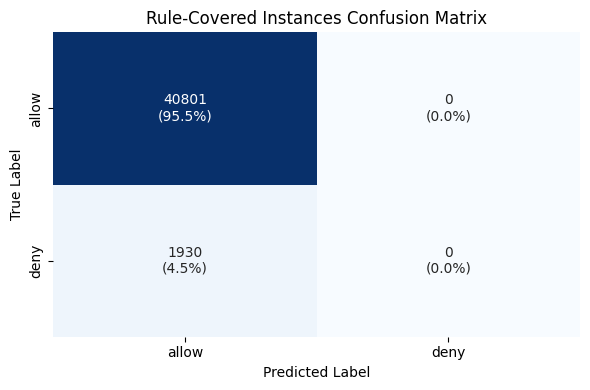

In [ ]:
if test_results['rule_covered_confusion_matrix'] is not None:
        print("Rule-Covered Confusion Matrix (Only Instances Covered by Rules):")
        plot_confusion_matrix(test_results['rule_covered_confusion_matrix'],

                            title='Rule-Covered Instances Confusion Matrix')

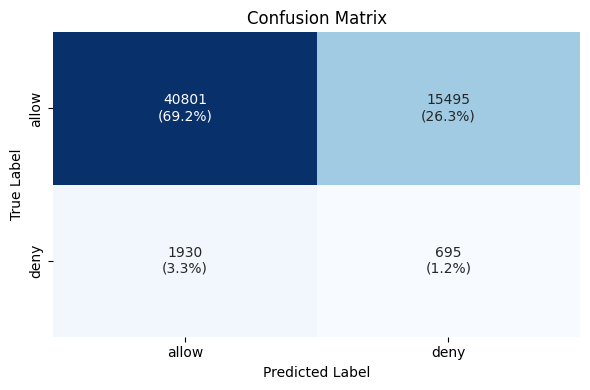

In [ ]:
 # Plot confusion matrix
if test_results and test_results['confusion_matrix'] is not None:
    plot_confusion_matrix(test_results['confusion_matrix'])

In [ ]:
def save_results_to_json(results, filename='rhapsody_results.json'):
    """Save results to JSON file"""
    # Convert numpy arrays to lists for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, dict):
            return {key: convert_numpy(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj

    results_clean = convert_numpy(results)

    with open(filename, 'w') as f:
        json.dump(results_clean, f, indent=2)

    print(f"Results saved to {filename}")

In [ ]:
# Save results
if test_results:
    save_results_to_json(test_results)

Results saved to rhapsody_results.json
